## Детектирование аномалий  

- [Часть 0. Введение](#Часть-0.-Введение)
- [Часть 1. Простые методы](#Часть-1.-Простые-методы)
    - [1.1. Box plot (ящик с усами)](#1.1.-Box-plot-(ящик-с-усами))
    - [1.2. Z-score](#1.2.-Z-score)
- [Часть 2. Elliptic Envelope](#Часть-2.-Elliptic-Envelope)
- [Часть 3. Одноклассовый SWM](#Часть-3.-Одноклассовый-SWM)
- [Часть 4. Изолирующий лес (Isolation Forest)](#Часть-4.-Изолирующий-лес-(Isolation-Forest))
- [Часть 5. Раздеяющие поверхности для разных алгоритмов](#Часть-5.-Раздеяющие-поверхности-для-разных-алгоритмов)
    - [5.1. OneClassSVM](#5.1.-OneClassSVM)
    - [5.2. IsolationForest](#5.2.-IsolationForest)
    - [5.3. EllipticEnvelope](#5.3.-EllipticEnvelope)
- [Часть 6. Библиотека PyOD](#Часть-6.-Библиотека-PyOD)

In [4]:
import numpy as np
from numpy import genfromtxt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

## Часть 0. Введение

**Задача поиска аномалий** (Anomaly Detection) - один из вариантов обучения без учителя (Unsupervised Learning):
обычно примеров аномалий или нет, или их достаточно мало.

Можно выделить два направления, занимающихся поиском аномалий:
1. Детектирование выбросов ([Outlier Detection](https://en.wikipedia.org/wiki/Anomaly_detection))
2. Детектирование «новизны» ([Novelty Detection](https://en.wikipedia.org/wiki/Novelty_detection))

В статистике **выбросом** называют результат измерения, выделяющийся из общей выборки.

**Выбросы** являются следствием:

- ошибок в данных (неточности измерения, округления, неверной записи и т.п.)
- наличия шумовых объектов (неверно классифицированных объектов)
- присутствия объектов «других» выборок (например, показания сломавшегося датчика).

**«Новый объект»**, как и **выброс**,  — это объект, который отличается по своим свойствам от объектов (обучающей) выборки.  Но  в отличие от выброса, его в самой выборке пока нет (он появится через некоторое время, и задача как раз и заключается в том, чтобы обнаружить его при появлении). **Новизна**, как правило, появляется в результате принципиально нового поведения объекта.

<img src="https://alexanderdyakonov.files.wordpress.com/2017/04/fig_softoutlier.png" width="500">

На рисинке видно, что шум (noise) — это выброс «в слабом смысле» (он может немного размывать границы класса/кластера). Нас же интересуют, прежде всего, выбросы «в сильном смысле», которые искажают эти границы.

Практические приложения:
- Обнаружение подозрительных банковских операций (Credit-card Fraud)
- Обнаружение вторжений (Intrusion Detection)
- Обнаружение нестандартных игроков на бирже (инсайдеров)
- Обнаружение неполадок в механизмах по показаниям датчиков
- Медицинская диагностика (Medical Diagnosis)
- Сейсмология

## Часть 1. Простые методы

### 1.1. Box plot (ящик с усами)

Будем работать с набором данных [Boston house prices dataset](https://scikit-learn.org/stable/datasets/index.html#boston-dataset).

In [7]:
from sklearn.datasets import fetch_california_housing

In [8]:
# Загружаем данные
boston = fetch_california_housing(as_frame=True)

X = boston.data
y = boston.target

# Посмотрим на данные
columns = boston.feature_names
boston_df = pd.DataFrame(boston.data)
boston_df.columns = columns
boston_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


#### Построение Box plot

<img src="https://upload.wikimedia.org/wikipedia/commons/1/1a/Boxplot_vs_PDF.svg?uselang=ru" width="500">

Построим **box plot** для признака `DIS`.

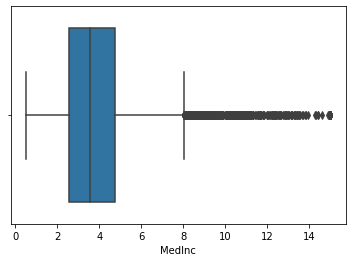

In [20]:
sns.boxplot(x=boston_df['MedInc']);

Как видно из графика, присутствует некоторое количество выбросов. Такой способ удобен для визуализации, но не для нахождения самих выбросов.

Исходя из методики построения ящика с усами, выбросами считаются точки, чьё значение признака $x$:
1. $x > Q_3 + 1.5*IQR$
2. $x < Q_1 - 1.5*IQR$

где **интерквартильный размах** $IQR = Q_3 - Q_1$

**Задание 1**

1. Найдите индексы выбросов для признака `DIS`
2. Исключите выбросы
3. Постройте box plot для `DIS`

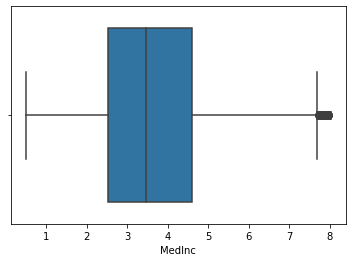

In [21]:
#------------------------------------------------
# Ваш код здесь
# outlier_idx = 
Q1 = boston_df['MedInc'].quantile(0.25)
Q3 = boston_df['MedInc'].quantile(0.75)
IQR = Q3 - Q1

outlier_idx = boston_df[(boston_df['MedInc'] < (Q1 - 1.5 * IQR)) | (boston_df['MedInc'] > (Q3 + 1.5 * IQR))].index
sns.boxplot(x=boston_df['MedInc'].drop(outlier_idx));
#------------------------------------------------

### 1.2. Z-score

**Стандартизованная оценка** (z-оценка, standard score, z-score) - это мера относительного разброса наблюдаемого или измеренного значения, которая показывает сколько стандартных отклонений составляет его разброс относительного среднего значения.

**Интуиция.**
Вычисляя Z-score, мы масштабируем и центрируем данные и смотрим на точки, которые находятся далеко от 0. 

$$\Large z = \frac{x - \bar{x}}{std}$$

где
- $\bar{x}$ - выборочное среднее
- $std$ - выборочное стандартное отклонение

Точки, которые достаточно далеко от 0, считаются выбросами. В большинстве случаев используется порог 3 или -3, т.е. если **Z-score** больше 3 или меньше -3, то точка считается выбросом.

**Замечание:** *`правило трёх сигм` гласит, что приблизительно с вероятностью 0,9973 значение нормально распределённой случайной величины лежит в интервале $\pm 3\sigma$).*


<img src="https://upload.wikimedia.org/wikipedia/commons/3/37/Standard_deviation_diagram_%28decimal_comma%29.svg?uselang=ru" width="500">

**Задание 2**

1. Найдите индексы выбросов для признака `DIS` используя **z-score**
2. Исключите выбросы
3. Постройте box plot для `DIS`

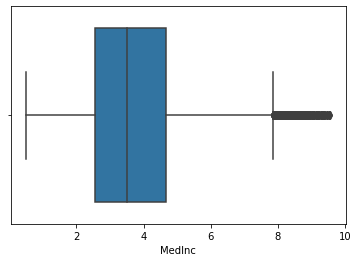

In [22]:
#------------------------------------------------
# Ваш код здесь
# outlier_idx = 
x_mean = boston_df['MedInc'].mean()
x_std = boston_df['MedInc'].std()

z_score = (boston_df['MedInc'] - x_mean) / x_std
z_score_abs = abs(z_score)

outlier_idx = boston_df[z_score_abs > 3].index

sns.boxplot(x=boston_df['MedInc'].drop(outlier_idx));
#------------------------------------------------

## Часть 2. Elliptic Envelope 

Будем считать, что распределение данных подчиняется многомерному нормальному распределению. Будем оценивать параметры этого распределения $\mu$ и $\Sigma$ по данным, где

- $\mu$ - вектор средних значений
- $\Sigma$ - ковариационная матрица.

Плотность вероятности:

$$\Large f_X(x_1, x_2, ...,x_k) = \frac{1}{\sqrt{(2\pi)^k |\Sigma|}} e^{-\frac{1}{2}(x - \mu)^T \Sigma^{-1}(x - \mu)}$$

<img src="https://upload.wikimedia.org/wikipedia/commons/8/8e/MultivariateNormal.png" width="500">

Аномалиями будем считать те объекты, вероятность появления которых мала.

**Задание 3**

Допишите следующие функции:

In [23]:
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score

# Возвращает оцененные параметры распределения
def estimateGaussian(dataset):
    #------------------------------------------------
    # Ваш код здесь
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    #------------------------------------------------
    return mu, sigma

# Возвращает вероятность для каждого объекта
def multivariateGaussian(dataset, mu, sigma):
    #------------------------------------------------
    # Ваш код здесь
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)
    #------------------------------------------------

# Возвращает лучшее значение f1 и лучший порог
def selectThresholdByCV(probs, target):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    
    stepsize = (max(probs) - min(probs)) / 1000;
    epsilons = np.arange(min(probs), max(probs), stepsize)
    
    for epsilon in np.nditer(epsilons):
        #------------------------------------------------
        # Ваш код здесь
        predictions = (probs < epsilon) 
        f = f1_score(target, predictions, average='binary')
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon
        #------------------------------------------------
    
    return best_f1, best_epsilon

Загружаем данные

In [24]:
! wget https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2022/seminars/sem14/cv_server_data.csv
! wget https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2022/seminars/sem14/gt_server_data.csv
! wget https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2022/seminars/sem14/tr_server_data.csv

--2023-03-09 13:04:38--  https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2022/seminars/sem14/cv_server_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4223 (4.1K) [text/plain]
Saving to: ‘cv_server_data.csv.1’

cv_server_data.csv. 100%[===================>]   4.12K  --.-KB/s    in 0s      

2023-03-09 13:04:38 (41.1 MB/s) - ‘cv_server_data.csv.1’ saved [4223/4223]

--2023-03-09 13:04:38--  https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2022/seminars/sem14/gt_server_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, await

In [25]:
columns_names = ['Latency (ms)', 'Throughput (mb/s)']

# Тренировочные данные
data_train = pd.read_csv('tr_server_data.csv', names=columns_names)

# Валидационные данные
data_val = pd.read_csv('cv_server_data.csv', names=columns_names)

# Значения target на валидационных данных
data_val_tr = pd.read_csv('gt_server_data.csv', names=['target'])

In [26]:
data_train.head()

,Latency (ms),Throughput (mb/s)
0,13.047,14.741
1,13.409,13.763
2,14.196,15.853
3,14.915,16.174
4,13.577,14.043


Построим график

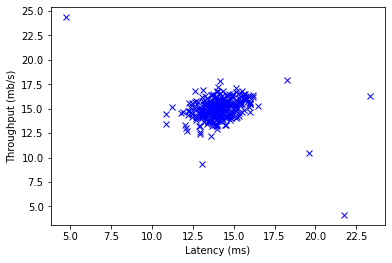

In [27]:
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.plot(data_train.iloc[:,0], data_train.iloc[:,1],'bx')
plt.show()

**Задание 4**

1. Оцените параметры распределения по тренировочным данным
2. Оцените вероятность для каждого объекта тренировочной выборки
3. Оцените вероятность для каждого объекта валидационной выборки
4. Выберите оптимальное значение порога
5. Найдите индексы аномальных объектов в тренировочной выборке
6. Постройте график, на котором аномальные объекты отображены крассным цветом

0.8750000000000001 9.036201327981212e-05


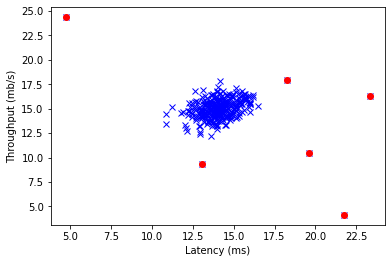

In [28]:
#------------------------------------------------
# Ваш код здесь
mu, sigma = estimateGaussian(data_train)

p = multivariateGaussian(data_train, mu, sigma)
p_cv = multivariateGaussian(data_val, mu, sigma)

fscore, ep = selectThresholdByCV(p_cv, data_val_tr)

print(fscore, ep)

outliers = np.asarray(np.where(p < ep))

plt.figure()
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.plot(data_train.iloc[:,0], data_train.iloc[:,1], 'bx')
plt.plot(data_train.iloc[outliers[0],0], data_train.iloc[outliers[0],1], 'ro')
plt.show()
#------------------------------------------------

## Часть 3. Одноклассовый SVM

Вариант метода опорных векторов, который отделяет выборку от начала координат. Использование ядер позволяет обойти сомнительное предположение о том, что объекты должны распологаться вдали от начала координат. По умолчанию, в качестве ядра используют лишь rbf (радиальные базисные функции), остальные ядра показывают плохие результаты.

**OneClassSVM** это скорее алгоритм поиска новизны, а не выбросов, т.к. «затачивается» под обучающую выборку.

In [29]:
from sklearn import svm

data_train = pd.read_csv('tr_server_data.csv', names=columns_names)

**Задание 5**

1. Обучите `OneClassSVM` с параметрами:
    - `nu=0.05`
    - `kernel="rbf"`
    - `gamma=0.1`
2. Сделайте предсказание для объектов тренировочной выборки
3. Постройте график, на котором аномальные объекты отображены красным цветом

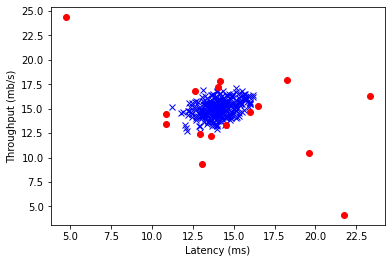

In [30]:
#------------------------------------------------
# Ваш код здесь
clf = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
clf.fit(data_train)

pred = clf.predict(data_train)

normal = data_train[pred == 1]
abnormal = data_train[pred == -1]

plt.figure()
plt.plot(normal.iloc[:,0],normal.iloc[:,1],'bx')
plt.plot(abnormal.iloc[:,0],abnormal.iloc[:,1],'ro')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()
#------------------------------------------------

## Часть 4. Изолирующий лес (Isolation Forest)

**Isolation Forest** ([оригинальная статья](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf?q=isolation-forest)) «изолирует» наблюдения следующим образом:
1. сначала, случайным образом выбирается признак,
2. затем, случайным образом выбирает *разделяющее значение* (split value) между максимальным и минимальным значениями выбранного признака.

Поскольку рекурсивное разбиение может быть представлено древовидной структурой, количество разбиений, необходимых для выделения объекта, эквивалентно длине пути от корневого узла до конечного узла.

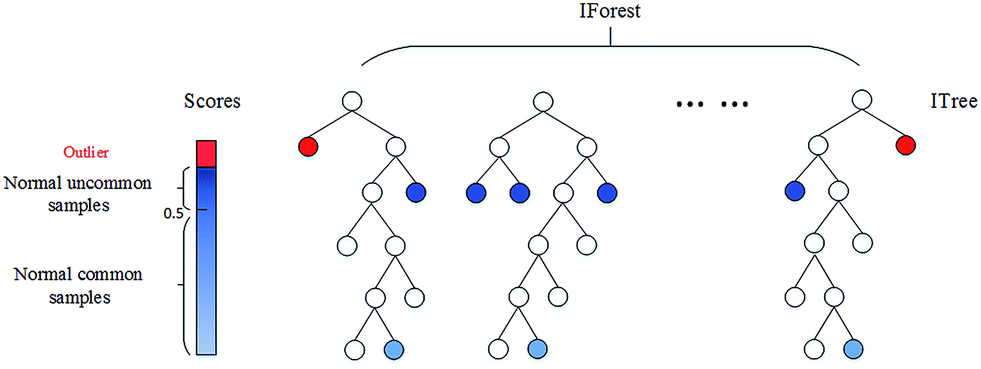

Эта длина пути, усредненная по лесу таких случайных деревьев, является мерой нормальности и нашей решающей функции.

$$\Large s(x, n) = 2^{-\frac{E(h(x))}{c(n)}}$$

где
- $h(x)$ - длина пути до наблюдения $x$
- $c(n)$ - средняя длина пути неудачного поиска в бинарном дереве поиска
- $n$ - количество внешних узлов

При случайном разбиении для аномальных объектов пути получаются заметно более короткими, чем для "нормальных" объектов. Следовательно, когда лес случайных деревьев в совокупности дает более короткие длины пути для конкретных объектов, они с большой вероятностью могут быть аномалиями.

Сгенерируем данные и посмотрим на них.

In [31]:
rng = np.random.RandomState(42)

# Тренировочные данные
X_train = 0.2 * rng.randn(1000, 2)
X_train = np.r_[X_train + 3, X_train]
X_train = pd.DataFrame(X_train, columns = ['x1', 'x2'])

# Тестовые данные - новые "нормальные" наблюдения
X_test = 0.2 * rng.randn(200, 2)
X_test = np.r_[X_test + 3, X_test]
X_test = pd.DataFrame(X_test, columns = ['x1', 'x2'])

# Аномальные данные
X_outliers = rng.uniform(low=-1, high=5, size=(50, 2))
X_outliers = pd.DataFrame(X_outliers, columns = ['x1', 'x2'])

Построим график

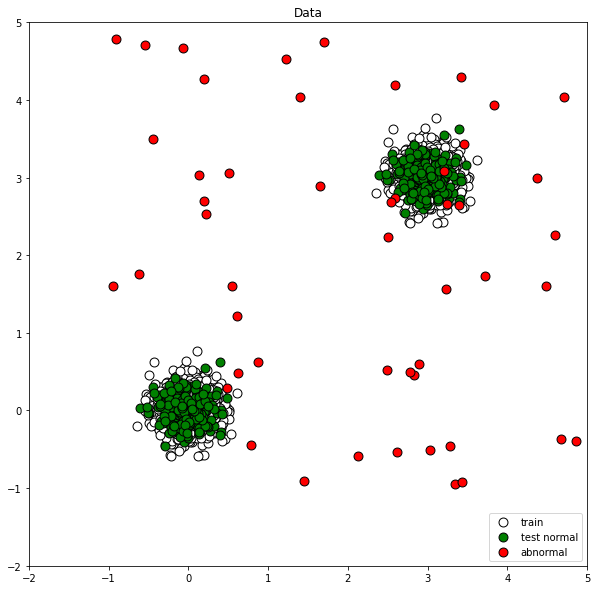

In [32]:
plt.figure(figsize=(10,10))
plt.title("Data")

p1 = plt.scatter(X_train.x1, X_train.x2, c='white', s=20*4, edgecolor='k')
p2 = plt.scatter(X_test.x1, X_test.x2, c='green', s=20*4, edgecolor='k')
p3 = plt.scatter(X_outliers.x1, X_outliers.x2, c='red', s=20*4, edgecolor='k')

plt.axis('tight')
plt.xlim((-2, 5))
plt.ylim((-2, 5))
plt.legend([p1, p2, p3], ["train", "test normal", "abnormal"], loc="lower right")

plt.show()

Обучим [`IsolationForest`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) и сделаем предсказание на наших данных

In [33]:
from sklearn.ensemble import IsolationForest

**Задание 6**

1. Обучите `IsolationForest` со следующими параметрами:
    - `max_samples=100`
    - `contamination=0.1` - доля выбросов в наборе данных
    - `random_state=rng`
2. Посчитайте долю верных ответов (accuracy) для тестовой "нормальной" выборки и для аномалий
3. Постройте scatter plot, на котором видно какие наблюдения изолирующий лес считает аномалиями

Accuracy (normal data): 0.93
Accuracy (outliers): 0.98


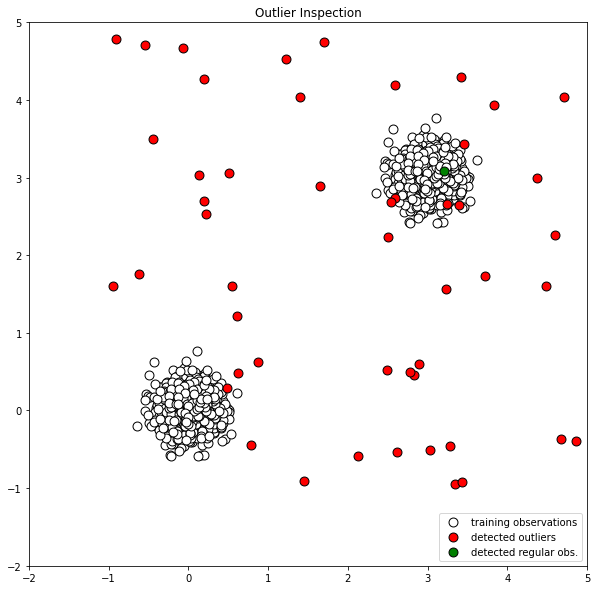

In [34]:
#------------------------------------------------
# Ваш код здесь

# Обучение модели
clf = IsolationForest(max_samples=100, contamination=0.1, random_state=rng)
clf.fit(X_train)

# Предсказание
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# Тестовая "нормальная" выборка
print("Accuracy (normal data):", len(y_pred_test[y_pred_test==1])/len(y_pred_test))

# Аномалии
print("Accuracy (outliers):", len(y_pred_outliers[y_pred_outliers==-1])/len(y_pred_outliers))

# adding the predicted label
X_outliers_pred = X_outliers.assign(y = y_pred_outliers)

plt.figure(figsize=(10,10))
plt.title("Outlier Inspection")

p1 = plt.scatter(X_train.x1, X_train.x2, c='white', s=20*4, edgecolor='k')
p2 = plt.scatter(X_outliers_pred.loc[X_outliers_pred.y == -1, ['x1']],  
                 X_outliers_pred.loc[X_outliers_pred.y == -1, ['x2']], 
                 c='red', s=20*4, edgecolor='k')
p3 = plt.scatter(X_outliers_pred.loc[X_outliers_pred.y == 1, ['x1']], 
                 X_outliers_pred.loc[X_outliers_pred.y == 1, ['x2']], 
                 c='green', s=20*4, edgecolor='k')

plt.axis('tight')
plt.xlim((-2, 5))
plt.ylim((-2, 5))
plt.legend([p1, p2, p3], ["training observations", "detected outliers", "detected regular obs."], loc="lower right")

plt.show()
#------------------------------------------------

## Часть 5. Разделяющие поверхности для разных алгоритмов

In [35]:
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

# чтобы был русский шрифт
import matplotlib
from matplotlib import rc
from scipy import stats

Сгенерируем данные

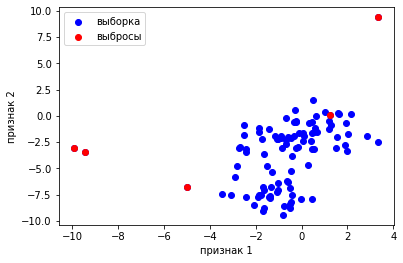

In [36]:
n = 100 # длина выборки
n_out = 5 # число выбросов


from sklearn.datasets import make_blobs

X = make_blobs(n_samples=n, n_features=2, centers=3, random_state=2, center_box=(-8.0, 8.0))[0]
X[:n_out,:] = 20*np.random.rand(n_out, 2) - 10
y = np.ones(n)
y[:n_out] = -1

plt.scatter(X[:,0], X[:,1], c='#0000FF', label='выборка')
plt.scatter(X[:n_out,0], X[:n_out,1], c='#FF0000', label='выбросы')
plt.xlabel(u'признак 1')
plt.ylabel('признак 2')
plt.legend();

In [37]:
xx, yy = np.meshgrid(np.linspace(-10, 10, 500), np.linspace(-10, 10, 500))

outliers_fraction = 0.1

In [38]:
# Функция для рисования областей
def run_and_plot(clf, X, outliers_fraction, draw_legend=True, title=''):
    clf.fit(X)
    print(clf)
    
    a_prob =  clf.decision_function(X)
    threshold = stats.scoreatpercentile(a_prob, 100 * outliers_fraction)
      
    print ('ошибка  = ' + str( (clf.predict(X) != y).mean()))

    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)


    plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 20), cmap=plt.cm.binary) # plt.cm.Blues_r cmap=plt.cm.Blues_r)
    a_ = plt.contour(xx, yy, Z, levels=[threshold], linewidths=1, colors='yellow')
    b_ = plt.scatter(X[y>0, 0], X[y>0, 1], c='white')
    c_ = plt.scatter(X[y<0, 0], X[y<0, 1], c='red')
    plt.axis('tight')
    if draw_legend:
        plt.legend(
            [a_.collections[0], b_, c_],
            [u'разделяющая поверхность', u'нормальные объекты', u'выбросы'],
            prop=matplotlib.font_manager.FontProperties(size=11), loc='upper right')
    plt.title(title)

### 5.1. OneClassSVM

OneClassSVM(gamma=0.1, nu=0.14500000000000002)
ошибка  = 0.13


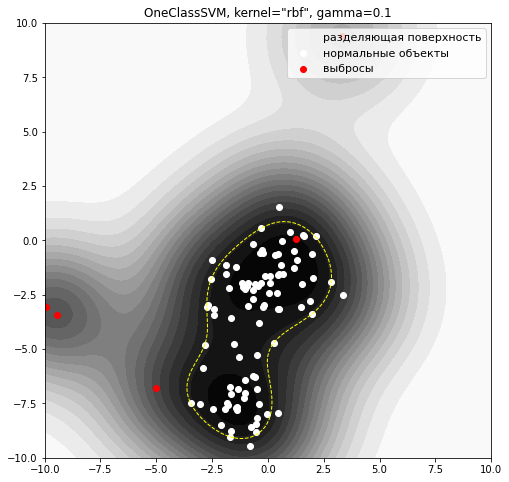

In [39]:
clf = svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05, kernel="rbf", gamma=0.1)

run_and_plot(clf, X, outliers_fraction=outliers_fraction, draw_legend=True, title='OneClassSVM, kernel="rbf", gamma=0.1')

OneClassSVM(degree=5, kernel='poly', nu=0.14500000000000002)
ошибка  = 0.52


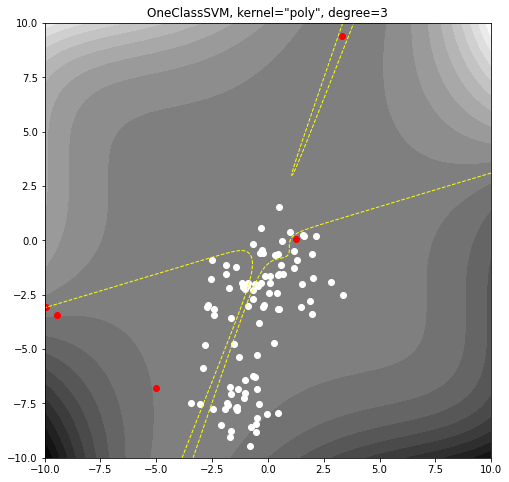

In [40]:
clf = svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05, kernel="poly", degree=5)
run_and_plot(clf, X, outliers_fraction=outliers_fraction, draw_legend=False, title='OneClassSVM, kernel="poly", degree=3')

### 5.2. IsolationForest

IsolationForest(contamination=0.1, n_jobs=1)
ошибка  = 0.07


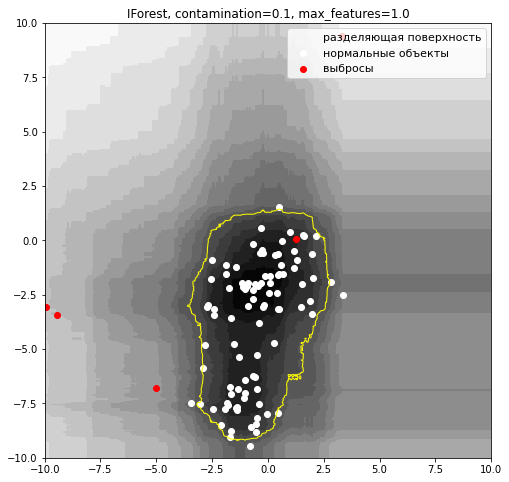

In [41]:
clf  = IsolationForest(n_estimators=n, max_samples='auto', contamination=0.1, max_features=1.0,
                       bootstrap=False, n_jobs=1, random_state=None, verbose=0)

run_and_plot(clf, X, outliers_fraction=outliers_fraction, draw_legend=True, title='IForest, contamination=0.1, max_features=1.0')

### 5.3. EllipticEnvelope

EllipticEnvelope(contamination=0.2)
ошибка  = 0.19


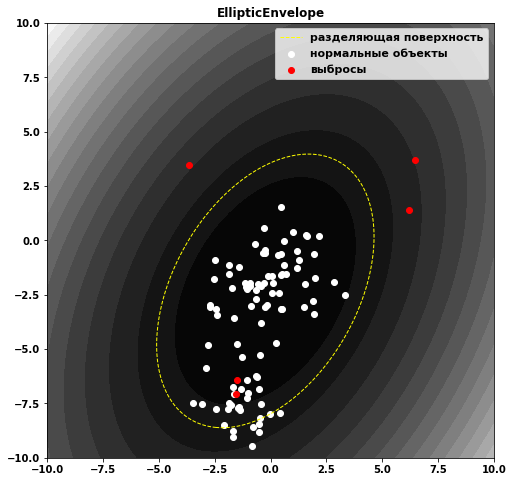

In [ ]:
clf = EllipticEnvelope(store_precision=True, assume_centered=False, support_fraction=None, contamination=0.2, random_state=None)

run_and_plot(clf, X, outliers_fraction=outliers_fraction, draw_legend=True, title='EllipticEnvelope')

## Часть 6. Библиотека PyOD

In [42]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 KB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.0.8-py3-none-any.whl size=184055 sha256=1478e63afab14a752bdc59b5a4b17f424b0705dc95bb71e1c023726a031c72aa
  Stored in directory: /root/.cache/pip/wheels/90/2b/16/c9baeb5fcd94a8a5bc4ea786fef2122f5b9ab3a61a7fc0303a
Successfully built pyod


In [44]:
from __future__ import division
from __future__ import print_function

import os
import sys
from time import time

import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.io import loadmat

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
# from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA

from pyod.utils.utility import standardizer
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score

### Сгенерируем набор точек для задачи поиска выбросов

Populating the interactive namespace from numpy and matplotlib


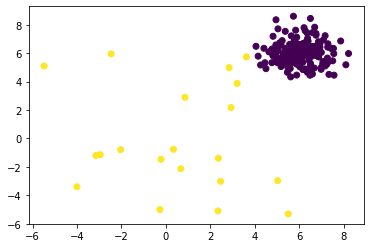

In [51]:
from pyod.utils.data import generate_data
from matplotlib import pylab as plt
%pylab inline

contamination = 0.1  # percentage of outliers
n_train = 200  # number of training points
n_test = 100  # number of testing points

# Generate sample data
X_train, X_test, y_train, y_test = \
    generate_data(n_train=n_train,
                  n_test=n_test,
                  n_features=2,
                  contamination=contamination,
                  random_state=42)

plt.scatter(X_train[:,0],X_train[:,1],c=y_train)
plt.show()

### Применим KNN для нахождения выбросов

In [52]:
from pyod.models.knn import KNN   # kNN detector

# train kNN detector
clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)

# get the prediction label and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

### Посмотрим на качество алгоритма

In [53]:
from pyod.utils.data import evaluate_print

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
KNN ROC:0.9992, precision @ rank n:0.95

On Test Data:
KNN ROC:1.0, precision @ rank n:1.0


### Визуализируем результат

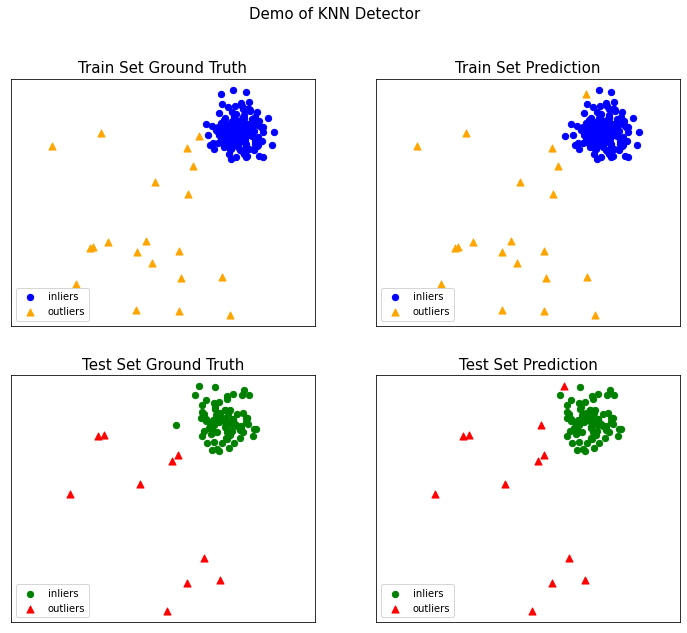

In [54]:
from pyod.utils.example import visualize
    
visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
    y_test_pred, show_figure=True, save_figure=False)

### Сравним различные алгоритмы для нахождения выбросов по времени работы и качеству

Загрузим данные и информацию о проценте выбросов

In [58]:
! wget https://github.com/Murcha1990/MLDS_ML_2022/blob/main/Занятие_15_anomalies/arrhythmia.mat

--2023-03-09 13:11:48--  https://github.com/Murcha1990/MLDS_ML_2022/blob/main/%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5_15_anomalies/arrhythmia.mat
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘arrhythmia.mat’

arrhythmia.mat          [ <=>                ] 140.48K  --.-KB/s    in 0.04s   

2023-03-09 13:11:49 (3.10 MB/s) - ‘arrhythmia.mat’ saved [143850]



In [60]:
mat_file = 'arrhythmia.mat'

random_state = np.random.RandomState(42)

df_columns = ['Characteristics', 'Data', '#Samples', '# Dimensions', 'Outlier Perc',
              'ABOD', 'CBLOF', 'HBOS', 'IForest', 'KNN', 'LOF', 'MCD',
              'OCSVM', 'PCA']

mat = loadmat(mat_file)

X = mat['X']
y = mat['y'].ravel()
outliers_fraction = np.count_nonzero(y) / len(y)
outliers_percentage = round(outliers_fraction * 100, ndigits=4)

# construct containers for saving results
roc_list = ['ROC-AUC',mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]
prn_list = ['Precision@N',mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]
time_list = ['Time', mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]

Разобъем данные на тренировочную и валидационную части и масштабируем их.

In [61]:
# 60% data for training and 40% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                    random_state=random_state)

# standardizing data for processing
X_train_norm, X_test_norm = standardizer(X_train, X_test)

Применим различные алгоритмы нахождения выбросов

In [62]:
from time import time

classifiers = {'Angle-based Outlier Detector (ABOD)': ABOD(
    contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor': CBLOF(
        contamination=outliers_fraction, check_estimator=False,
        random_state=random_state),
    # 'Feature Bagging': FeatureBagging(contamination=outliers_fraction,
    #                                  random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
    'Local Outlier Factor (LOF)': LOF(
        contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
}

for clf_name, clf in classifiers.items():
    t0 = time()
    #обучите алгоритм на X_train_norm
    clf.fit(X_train_norm)
    #test_scores = сделайте предсказание (decision_function) на X_test_norm
    test_scores = clf.decision_function(X_test_norm)
    t1 = time()
    duration = round(t1 - t0, ndigits=4)
    time_list.append(duration)

    #вычислите roc_auc_score и precision_n_scores для тестовых данных (y_test, test_scores)
#     roc = #your code here
#     prn = #your code here
    roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
    prn = round(precision_n_scores(y_test, test_scores), ndigits=4)

    print('{clf_name} ROC:{roc}, precision @ rank n:{prn}, '
          'execution time: {duration}s'.format(
        clf_name=clf_name, roc=roc, prn=prn, duration=duration))

    roc_list.append(roc)
    prn_list.append(prn)
    

df_time = pd.DataFrame([time_list],columns=df_columns)
df_roc = pd.DataFrame([roc_list],columns=df_columns)
df_prn = pd.DataFrame([prn_list],columns=df_columns)

df_res = pd.concat([df_time, df_roc, df_prn], axis=0)

Angle-based Outlier Detector (ABOD) ROC:0.7687, precision @ rank n:0.3571, execution time: 5.8702s
Cluster-based Local Outlier Factor ROC:0.7789, precision @ rank n:0.4643, execution time: 3.5695s
Histogram-base Outlier Detection (HBOS) ROC:0.8511, precision @ rank n:0.5714, execution time: 1.7236s
Isolation Forest ROC:0.8616, precision @ rank n:0.6071, execution time: 0.4148s
K Nearest Neighbors (KNN) ROC:0.782, precision @ rank n:0.5, execution time: 0.053s
Local Outlier Factor (LOF) ROC:0.7787, precision @ rank n:0.4643, execution time: 0.01s
Minimum Covariance Determinant (MCD) ROC:0.8228, precision @ rank n:0.4286, execution time: 2.8864s
One-class SVM (OCSVM) ROC:0.7986, precision @ rank n:0.5, execution time: 0.0809s
Principal Component Analysis (PCA) ROC:0.7997, precision @ rank n:0.5, execution time: 0.1722s


In [63]:
#выведите на экран таблицу с результатами
df_res

,Characteristics,Data,#Samples,# Dimensions,Outlier Perc,ABOD,CBLOF,HBOS,IForest,KNN,LOF,MCD,OCSVM,PCA
0,Time,arrhythmia,452,274,14.6018,5.8702,3.5695,1.7236,0.4148,0.053,0.0100,2.8864,0.0809,0.1722
0,ROC-AUC,arrhythmia,452,274,14.6018,0.7687,0.7789,0.8511,0.8616,0.782,0.7787,0.8228,0.7986,0.7997
0,Precision@N,arrhythmia,452,274,14.6018,0.3571,0.4643,0.5714,0.6071,0.500,0.4643,0.4286,0.5000,0.5000


### Попробуем определить долю выбросов в датасете

In [69]:
!wget https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Занятие_15_anomalies/heart.csv

--2023-03-09 13:16:06--  https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5_15_anomalies/heart.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11328 (11K) [text/plain]
Saving to: ‘heart.csv’

heart.csv           100%[===================>]  11.06K  --.-KB/s    in 0s      

2023-03-09 13:16:06 (83.4 MB/s) - ‘heart.csv’ saved [11328/11328]



In [70]:
data = pd.read_csv("heart.csv")
X = data.copy()
y = data['target']
del X['target']
print(data.shape)

(303, 14)


In [72]:
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

age         13.5
sex          1.0
cp           2.0
trestbps    20.0
chol        63.5
fbs          0.0
restecg      1.0
thalach     32.5
exang        1.0
oldpeak      1.6
slope        1.0
ca           1.0
thal         1.0
dtype: float64


In [73]:
X_wo_out = X[~((X < (Q1 - 3 * IQR)) | (X > (Q3 + 3 * IQR))).any(axis=1)] #ищем сильные выбросы
y_wo_out = y[~((X < (Q1 - 3 * IQR)) | (X > (Q3 + 3 * IQR))).any(axis=1)]

In [74]:
X_wo_out.shape, y_wo_out.shape

((257, 13), (257,))

In [75]:
len(X_wo_out) / len(X)

0.8481848184818482

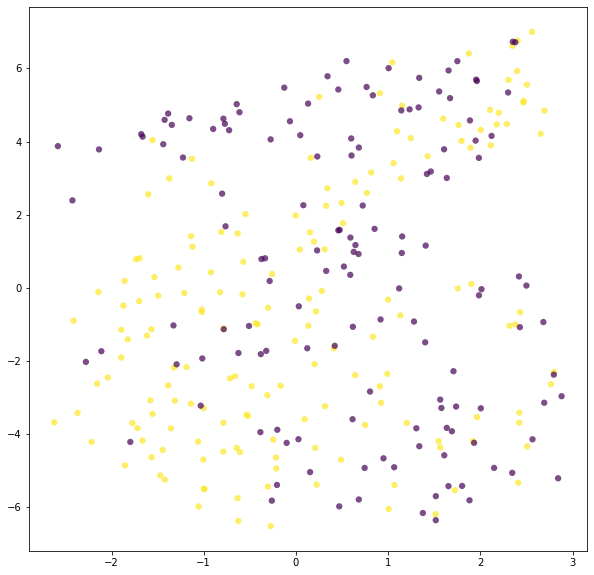

CPU times: user 5.73 s, sys: 145 ms, total: 5.88 s
Wall time: 4.72 s


In [81]:
%%time

from sklearn.manifold import TSNE

tsne = TSNE(perplexity=100)

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, edgecolor='none', alpha=0.7, s=40)
plt.show()

In [82]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

cross_val_score(LogisticRegression(), X, y, cv=3).mean() # на грязных данных

0.8316831683168316

In [83]:
cross_val_score(LogisticRegression(), X_wo_out, y_wo_out, cv=3).mean() # убрали выбросы с пом.boxplot

0.8208390332877337

In [86]:
outliers_fraction = 0.15

classifiers = {'Angle-based Outlier Detector (ABOD)': ABOD(
    contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor': CBLOF(
        contamination=outliers_fraction, check_estimator=False,
        random_state=random_state),
    # 'Feature Bagging': FeatureBagging(contamination=outliers_fraction,
    #                                  random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
    'Local Outlier Factor (LOF)': LOF(
        contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
}

for clf_name, clf in classifiers.items():
    clf.fit(X)
    y_pred = clf.labels_ 
    
    X_wo = X[y_pred==0]
    y_wo = y[y_pred==0]
    
    print(clf_name, cross_val_score(LogisticRegression(), X_wo, y_wo, cv=3).mean())

Angle-based Outlier Detector (ABOD) 0.7974920200638396
Cluster-based Local Outlier Factor 0.8129502963976288
Histogram-base Outlier Detection (HBOS) 0.8365709074327405
Isolation Forest 0.8131326949384405
K Nearest Neighbors (KNN) 0.8013223894208847
Local Outlier Factor (LOF) 0.8168718650250798
Minimum Covariance Determinant (MCD) 0.8518923848609211
One-class SVM (OCSVM) 0.8247150022799817
Principal Component Analysis (PCA) 0.844186046511628
